In [ ]:
import cv2
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt 
%matplotlib inline 
import dlib
from scipy.spatial import Delaunay

## 1 Correspondence

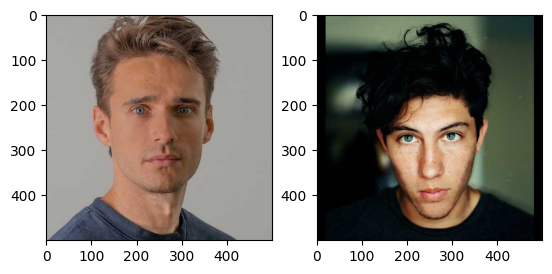

In [2]:
# photos from 
# https://unsplash.com/photos/WNoLnJo7tS8
# https://unsplash.com/photos/d2MSDujJl2g
# images resized and cropped to 500x500 in photoshop

raw_img_A = cv2.imread("imgA.jpg", cv2.IMREAD_COLOR)
A_resized = cv2.resize(raw_img_A, (500, 500), interpolation = cv2.INTER_AREA)
img_A = A_resized.astype(np.float32) / 255.

raw_img_B = cv2.imread("imgB.jpg", cv2.IMREAD_COLOR)
B_resized = cv2.resize(raw_img_B, (500, 500), interpolation = cv2.INTER_AREA)
img_B = B_resized.astype(np.float32) / 255.

# switch BGR to RGB
img_A = img_A[...,::-1]
img_B = img_B[...,::-1]

plt.subplot(1, 2, 1)
plt.imshow(img_A)
plt.subplot(1, 2, 2)
plt.imshow(img_B)

In [2]:
def landmarks(img_resized):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    # detect face bounding box
    box = detector(img_resized)[0]
    # predict landmarks
    pred = predictor(img_resized, box)
    mark_xy = np.zeros([68, 2])
            
    # get landmark coords
    for n in range(68):
        mark_xy[n, 0] = pred.part(n).x
        mark_xy[n, 1] = pred.part(n).y
        
                
    return mark_xy

In [ ]:
mark_A_xy = landmarks(A_resized)
mark_B_xy = landmarks(B_resized)

In [5]:
# adding some extra points just for fun

mark_A_xy = np.vstack((mark_A_xy, np.array([0, 0])))
mark_B_xy = np.vstack((mark_B_xy, np.array([0, 0])))
mark_A_xy = np.vstack((mark_A_xy, np.array([0, 499])))
mark_B_xy = np.vstack((mark_B_xy, np.array([0, 499])))
mark_A_xy = np.vstack((mark_A_xy, np.array([499, 0])))
mark_B_xy = np.vstack((mark_B_xy, np.array([499, 0])))
mark_A_xy = np.vstack((mark_A_xy, np.array([499, 499])))
mark_B_xy = np.vstack((mark_B_xy, np.array([499, 499])))


# add points to forehead
mark_A_xy = np.vstack((mark_A_xy, np.array([250, 80])))
mark_B_xy = np.vstack((mark_B_xy, np.array([250, 180])))
mark_A_xy = np.vstack((mark_A_xy, np.array([150, 120])))
mark_B_xy = np.vstack((mark_B_xy, np.array([190, 195])))
mark_A_xy = np.vstack((mark_A_xy, np.array([140, 180])))
mark_B_xy = np.vstack((mark_B_xy, np.array([165, 225])))
mark_A_xy = np.vstack((mark_A_xy, np.array([195, 85])))
mark_B_xy = np.vstack((mark_B_xy, np.array([220, 185])))
mark_A_xy = np.vstack((mark_A_xy, np.array([335, 120])))
mark_B_xy = np.vstack((mark_B_xy, np.array([325, 190])))
mark_A_xy = np.vstack((mark_A_xy, np.array([305, 90])))
mark_B_xy = np.vstack((mark_B_xy, np.array([288, 180])))
mark_A_xy = np.vstack((mark_A_xy, np.array([350, 165])))
mark_B_xy = np.vstack((mark_B_xy, np.array([345, 220])))


# points for hair
mark_A_xy = np.vstack((mark_A_xy, np.array([150, 30])))
mark_B_xy = np.vstack((mark_B_xy, np.array([170, 70])))
mark_A_xy = np.vstack((mark_A_xy, np.array([110, 80])))
mark_B_xy = np.vstack((mark_B_xy, np.array([130, 120])))
mark_A_xy = np.vstack((mark_A_xy, np.array([100, 140])))
mark_B_xy = np.vstack((mark_B_xy, np.array([110, 200])))
mark_A_xy = np.vstack((mark_A_xy, np.array([340, 25])))
mark_B_xy = np.vstack((mark_B_xy, np.array([340, 60])))
mark_A_xy = np.vstack((mark_A_xy, np.array([380, 100])))
mark_B_xy = np.vstack((mark_B_xy, np.array([380, 160])))
mark_A_xy = np.vstack((mark_A_xy, np.array([250, 5])))
mark_B_xy = np.vstack((mark_B_xy, np.array([250, 50])))

In [6]:
def plot_landmarks(img_A, img_B, mark_A_xy, mark_B_xy):
    plt.subplot(1, 2, 1)
    plt.imshow(img_A)
    plt.scatter(mark_A_xy[:, 0], mark_A_xy[:, 1], s=3, c='red')
    plt.subplot(1, 2, 2)
    plt.imshow(img_B)
    plt.scatter(mark_B_xy[:, 0], mark_B_xy[:, 1], s=3, c='red')

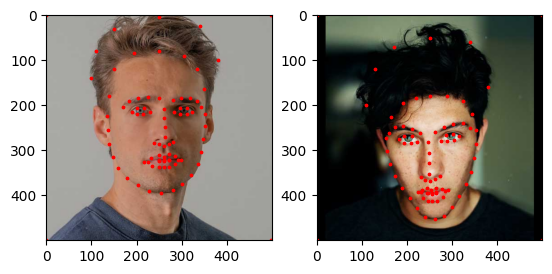

In [7]:
plot_landmarks(img_A, img_B, mark_A_xy, mark_B_xy)

## 2 Mesh

In [8]:
def get_triangles(mark_A_xy, mark_B_xy, w):
    in_between = np.zeros(mark_A_xy.shape)
    counter = 0
    for pa, pb in zip(mark_A_xy, mark_B_xy):
        # find the in between point for each landmark in image A and B
        in_between[counter, 0] = (1 - w) * pa[0] + w * pb[0]
        in_between[counter, 1] = (1 - w) * pa[1] + w * pb[1]
        counter += 1
    
    triangles = Delaunay(in_between).simplices
        
    return triangles

In [9]:
triangles = get_triangles(mark_A_xy, mark_B_xy, 0.5)

In [10]:
def plot_triangles(img_A, img_B, triangles):
    plt.subplot(1, 2, 1)
    plt.imshow(img_A)
    for tri in triangles:
        vertex = mark_A_xy[tri, :]
        # polygon code inspired by https://stackoverflow.com/questions/44397105/how-to-draw-a-triangle-using-matplotlib-pyplot-based-on-3-dots-x-y-in-2d
        triangle = plt.Polygon(vertex, facecolor='none', edgecolor='white', linewidth=0.5)
        plt.gca().add_patch(triangle)

    plt.subplot(1, 2, 2)
    plt.imshow(img_B)
    for tri in triangles:
        vertex = mark_B_xy[tri, :]
        triangle = plt.Polygon(vertex, facecolor='none', edgecolor='white', linewidth=0.5)
        plt.gca().add_patch(triangle)

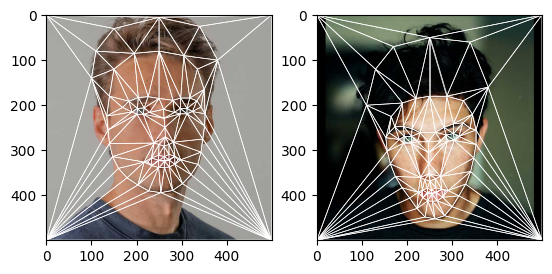

In [11]:
plot_triangles(img_A, img_B, triangles)

## 3 Blending with a mesh

In [12]:
def affine_matrices(mark_A_xy, mark_B_xy, triangles, w):
    I_to_A = []
    I_to_B = []
    # list of pixel positions for the in between img
    in_betweens = []
    for tri in triangles:
        vertex_A = mark_A_xy[tri, :]
        vertex_B = mark_B_xy[tri, :]

        in_between = (1 - w) * vertex_A + w * vertex_B
        in_betweens.append(in_between.astype(int))

        # reshape to vertical vectors and add w=1
        A = np.hstack((vertex_A, np.ones([3, 1])))
        B = np.hstack((vertex_B, np.ones([3, 1])))
        in_between = np.hstack((in_between, np.ones([3, 1])))
        in_between = in_between.astype(int)

        # calculate the transformation matrix from A to intermediate
        AT = np.linalg.solve(A, in_between)
        # inverse for inverse warping, now intermediate to A    
        AT = np.linalg.inv(AT)
        I_to_A.append(AT)
    
        # calculate the transformation matrix from B to intermediate
        AT = np.linalg.solve(B, in_between)
        # inverse for inverse warping, now intermediate to B    
        AT = np.linalg.inv(AT)
        I_to_B.append(AT)        

    return I_to_A, I_to_B, in_betweens

In [13]:
def morph_face(img_A, img_B, I_to_A, I_to_B, in_betweens, w):
    img_new = np.zeros(img_B.shape)
    arr = []

    for TA, TB, tri in zip(I_to_A, I_to_B, in_betweens):
        # the bounding box of the triangle
        top_left = np.min(tri, axis=0).astype(int)
        bottom_right = np.max(tri, axis=0).astype(int)

        # method for finding pixel inside triangle inspired by https://stackoverflow.com/questions/21339448/how-to-get-list-of-points-inside-a-polygon-in-python    
        triangle = plt.Polygon(tri)

        # loop through bounding box for each triangle
        # process pixels that are in said triangle
        for i in range(top_left[0], bottom_right[0] + 1):
            for j in range(top_left[1], bottom_right[1] + 1):
                point = np.array([i, j]).reshape(1,2)
                # check if point is in triangle
                if triangle.contains_points(point)[0]:
                    point = np.hstack((point.reshape(2,), np.ones(1)))
                    pa = np.dot(point, TA).astype(int) 
                    pb = np.dot(point, TB).astype(int) 
                    # blend colors
                    img_new[j, i] = (1 - w) * img_A[pa[1], pa[0]] + w * img_B[pb[1], pb[0]]   
    return img_new

In [14]:
faces = []
for i in range(0, 12, 2):
    w = i / 10
    I_to_A, I_to_B, in_betweens = affine_matrices(mark_A_xy, mark_B_xy, triangles, w)
    new_img = morph_face(img_A, img_B, I_to_A, I_to_B, in_betweens, w)
    faces.append(new_img)

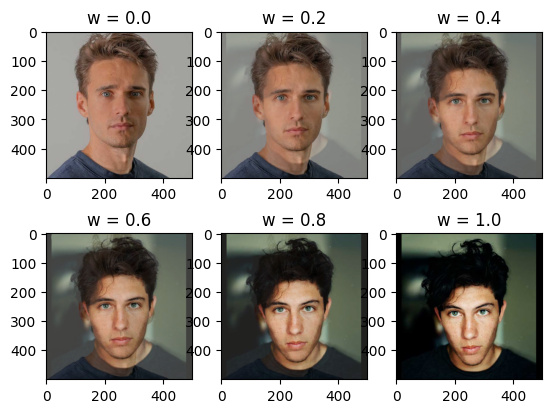

In [15]:
for i in range(2):
    for j in range(3):
        plt.subplot(2, 3, j+i*3+1)
        plt.imshow(faces[j+i*3])
        plt.title("w = " + str((j+i*3)/10*2))

## 4 Capture

In [16]:
faces = []
for i in range(0, 102, 2):
    w = i / 100
    I_to_A, I_to_B, in_betweens = affine_matrices(mark_A_xy, mark_B_xy, triangles, w)
    new_img = morph_face(img_A, img_B, I_to_A, I_to_B, in_betweens, w)
    faces.append(new_img)

In [17]:
out = cv2.VideoWriter('meshed.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (500,500))
for face in faces:
    # 0-1 to 0-255
    face = face * 255
    face = np.uint8(face)
    # rgb to bgr
    face = face[...,::-1]
    out.write(face)
out.release()

In [ ]:
meshless_faces = []
for i in range(0, 102, 2):
    w = i / 100
    new_img = blend_face(img_A, img_B, mark_A_xy, mark_B_xy, w)
    meshless_faces.append(new_img)

In [187]:
out = cv2.VideoWriter('meshless.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (500,500))
for face in meshless_faces:
    # 0-1 to 0-255
    face = face * 255
    face = np.uint8(face)
    # rgb to bgr
    face = face[...,::-1]
    out.write(face)
out.release()